# DEG genes & ACR target genes consensus

### load library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from IPython.display import Image, display_png
%config InlineBackend.figure_formats = {'png', 'retina'}

### load gff data

In [2]:
gff = pd.read_csv("TAIR10_GFF3_genes.gff", sep="\t", header=None)
gff = gff.loc[gff.iloc[:,2] == "gene", :]

## Function to annotate genes for dACRs.

In [3]:
# function to annotate genes for dACRs
def get_dACR(peak_file, cACR, gff):
    
    all_peak = pd.read_csv(peak_file, sep="\t", header=None)

    cACR = np.unique(cACR.peak.str[1:].astype(int)-1)
    not_annotated_peak = [i for i in all_peak.index.values if i not in cACR]
    not_annotated_peak = all_peak.iloc[not_annotated_peak, :]
    
    dACR = []
    for i in range(not_annotated_peak.shape[0]):
        chrom = not_annotated_peak.iloc[i, 0]
        start = not_annotated_peak.iloc[i, 1]
        end = not_annotated_peak.iloc[i, 2]

        if gff[(gff.iloc[:, 0] == chrom) & (gff.iloc[:, 3] <= start) & (gff.iloc[:, 4] >= end)].shape[0] > 0:
            pass
        else:
            tmp_gff1 = gff[(gff.iloc[:, 0] == chrom) & (gff.iloc[:, 4] <= start)]
            tmp_gff2 = gff[(gff.iloc[:, 0] == chrom) & (gff.iloc[:, 3] >= end)]
            if tmp_gff1.shape[0] < 1:
                if tmp_gff2.iloc[0, 6] == "+":
                    dACR.append([chrom, start, end, tmp_gff2.iloc[0, 3] - end, tmp_gff2.iloc[0, 8][3:12]])
            elif tmp_gff2.shape[0] < 1:
                if tmp_gff1.iloc[-1, 6] == "-":
                    dACR.append([chrom, start, end, start - tmp_gff1.iloc[-1, 4], tmp_gff1.iloc[-1, 8][3:12]])
            else:
                if tmp_gff1.iloc[-1, 6] == "+":
                    if tmp_gff2.iloc[0, 6] == "-":
                        pass
                    else:
                        dACR.append([chrom, start, end, tmp_gff2.iloc[0, 3] - end, tmp_gff2.iloc[0, 8][3:12]])
                else:
                    if tmp_gff2.iloc[0, 6] == "-":
                        dACR.append([chrom, start, end, start - tmp_gff1.iloc[-1, 4], tmp_gff1.iloc[-1, 8][3:12]])
                    else:
                        ## shared dACR peak
                        pass
    dACR = pd.DataFrame(dACR)
    dACR.columns = ["chr", "start", "end", "distance", "target"]
    return dACR

In [4]:
# function to check common genes between DEG and ACR & make venn diagram
def check_consistent(peak_file, cACR_file, up_regulated_genes, gff):
    cACR = pd.read_csv(cACR_file, sep=" ")
    dACR = get_dACR(peak_file, cACR, gff)

    ACRs = list(cACR.feature)
    ACRs.extend(list(dACR.target))
    ACRs = np.unique(ACRs)
    
    # common in ACR & DEG
    common = list(set(ACRs) & set(up_regulated_genes)) #;pd.DataFrame(common).to_csv("common_genes.csv")
    
    ACR_specific = len(ACRs) - len(common)
    DEG_specific = len(up_regulated_genes) - len(common)
    venn2(subsets = (ACR_specific, DEG_specific, len(common)), set_labels = ("ACR", "DEG"))
    return ACRs, up_regulated_genes, common

### a4 vs un

a4 vs un


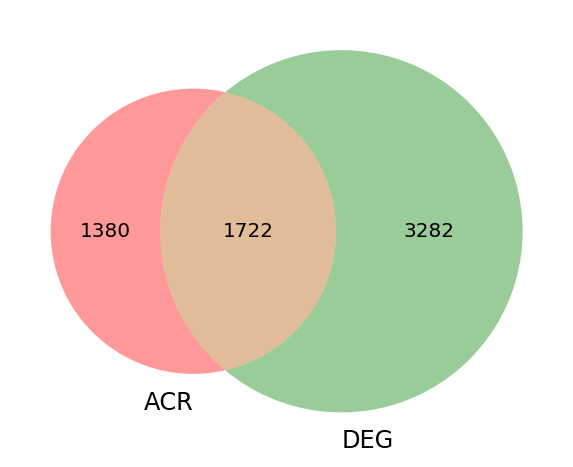

In [5]:
### a4 vs un
DEG = pd.read_csv("../DEG/Significant DE genes list and statistics.csv")
a4_vs_un_DEG = DEG[(DEG["contrast"] == "wt.a4-wt.un") & (DEG["up.down"] == "up-regulated")]
a4_vs_un_DEG = np.unique(a4_vs_un_DEG.target.values)

print("a4 vs un")
a4_ACRs, a4_DEGs, a4_common = check_consistent("wt_a4_vs_un_peaks.narrowPeak", "wt_a4_vs_un_peaks_annotation.txt", a4_vs_un_DEG, gff)

### kv vs un

kv vs un


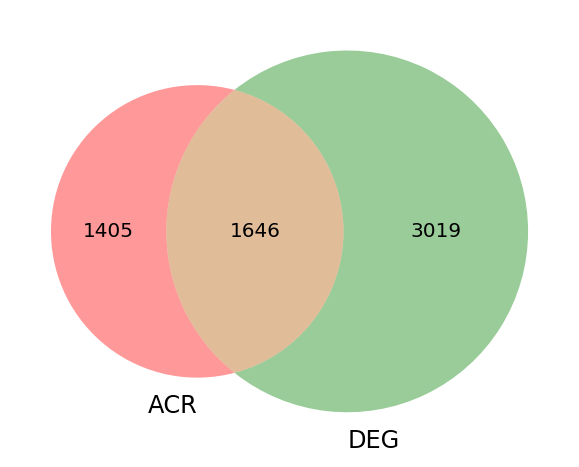

In [6]:
### kv vs un
DEG = pd.read_csv("../DEG/Significant DE genes list and statistics.csv")
kv_vs_un_DEG = DEG[(DEG["contrast"] == "wt.kv-wt.un") & (DEG["up.down"] == "up-regulated")]
kv_vs_un_DEG = np.unique(kv_vs_un_DEG.target.values)

print("kv vs un")
kv_ACRs, kv_DEGs, kv_common = check_consistent("wt_kv_vs_un_peaks.narrowPeak", "wt_kv_vs_un_peaks_annotation.txt", kv_vs_un_DEG, gff)

### setiwt_e2 vs setiwt_mk

setiwt_e2 vs setiwt_mk


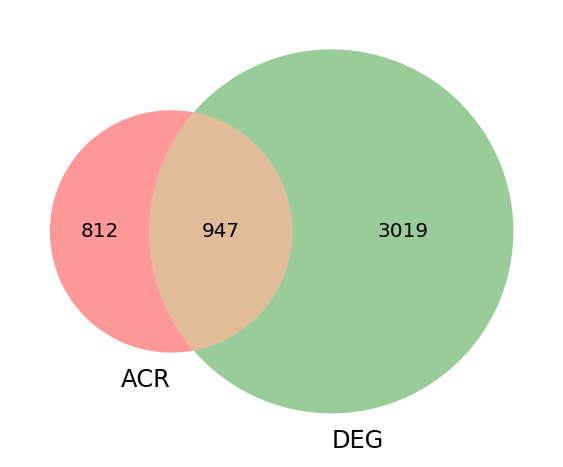

In [7]:
### setiwt_e2 vs setiwt_mk
DEG = pd.read_csv("../DEG/DE gene testing statistics.csv")
setie2_vs_mk_DEG = DEG[(DEG["contrast"] == "seti.est4h-seti.est0h") & (DEG["log2FC"] >= 1)]
setie2_vs_mk_DEG = np.unique(setie2_vs_mk_DEG.target.values)

print("setiwt_e2 vs setiwt_mk")
setiwte2_ACRs, setiwte2_DEGs, setiwte2_common = check_consistent("setiwt_e2_vs_mk_peaks.narrowPeak", "setiwt_e2_vs_mk_peaks_annotation.txt", setie2_vs_mk_DEG, gff)

### comonn a4 and kv

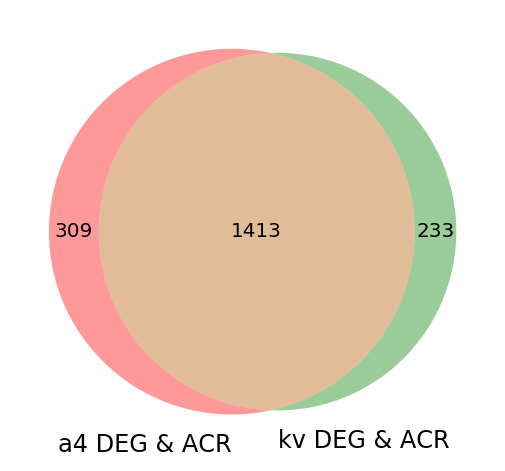

In [8]:
venn2(subsets = (len(a4_common) - len(list(set(a4_common) & set(kv_common))),
                 len(kv_common) - len(list(set(a4_common) & set(kv_common))),
                 len(list(set(a4_common) & set(kv_common)))),
set_labels = ("a4 DEG & ACR", "kv DEG & ACR"))

# GO analysis

### function to make bar plot

In [9]:
def make_GO_top5_bar(GO_result):
    GO = pd.read_csv(GO_result)
    GO_BP = GO[GO["source"] == "GO:BP"].iloc[0:5, :]
    GO_MF = GO[GO["source"] == "GO:MF"].iloc[0:5, :]
    GO_CC = GO[GO["source"] == "GO:CC"].iloc[0:5, :]

    colors = ["#C76527", "#459C75", "#3170AD"]

    for i, each in enumerate([GO_BP,GO_MF,GO_CC]):
        plt.figure(figsize=(6, 1.8))
        plt.barh(range(5), each.negative_log10_of_adjusted_p_value[::-1], align='center', color=colors[i])
        plt.yticks(range(5), each.term_name[::-1])
        plt.xlim(0, 70)
        plt.show()

### a4 vs un

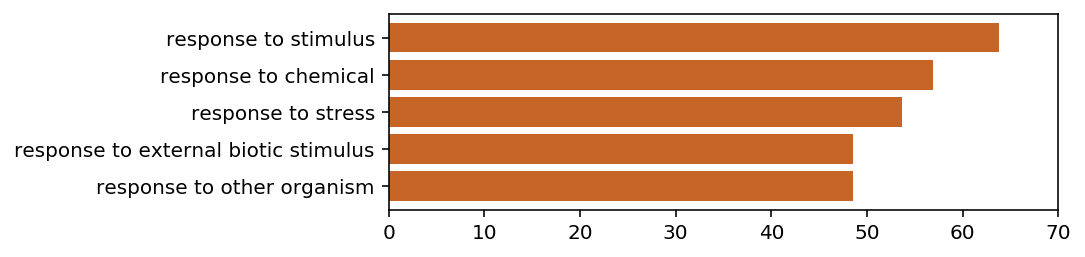

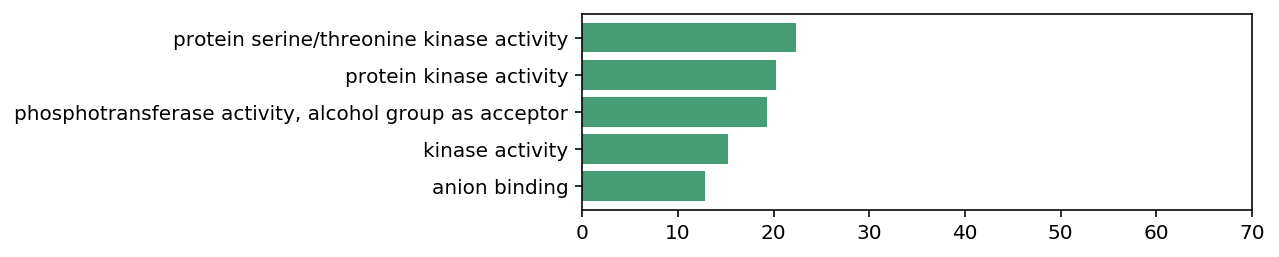

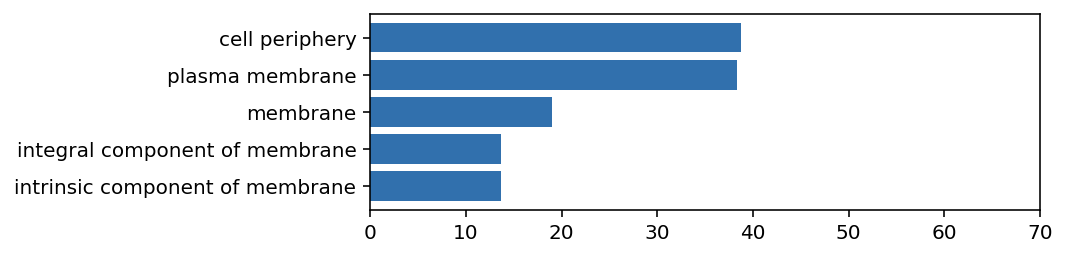

In [10]:
make_GO_top5_bar("a4_GO.csv")

### kv vs un

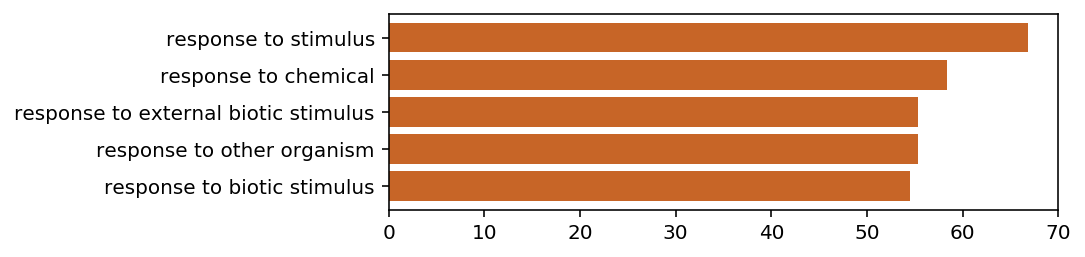

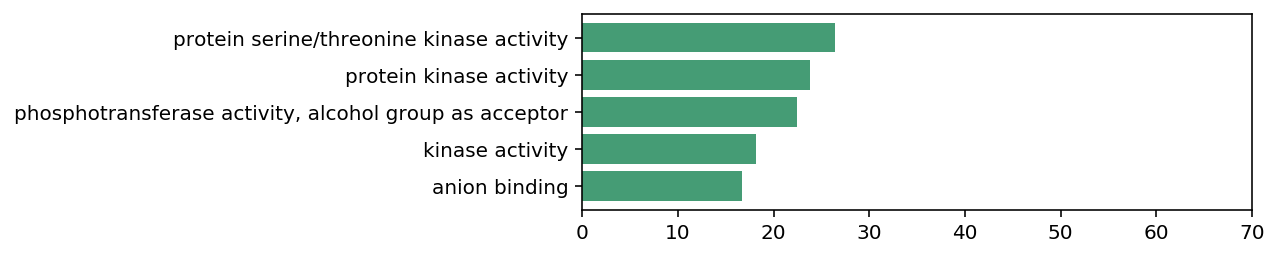

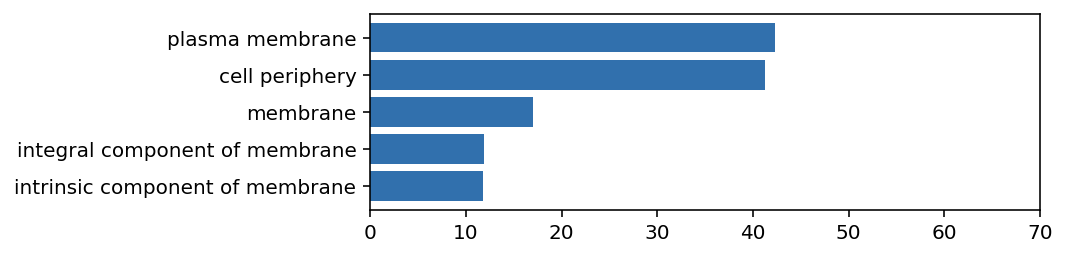

In [11]:
make_GO_top5_bar("kv_GO.csv")

### setiwt_e2 vs setiwt_mk

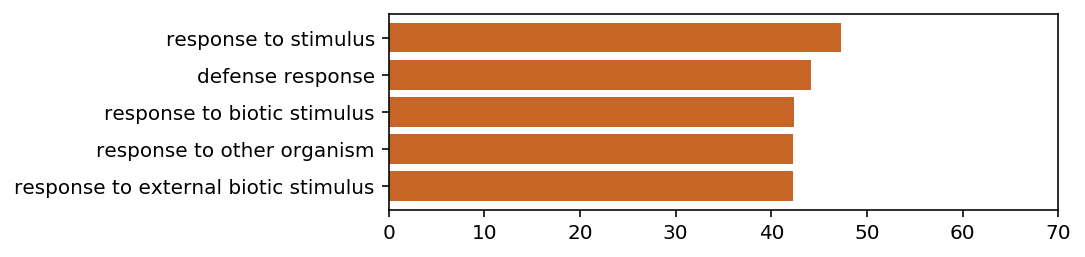

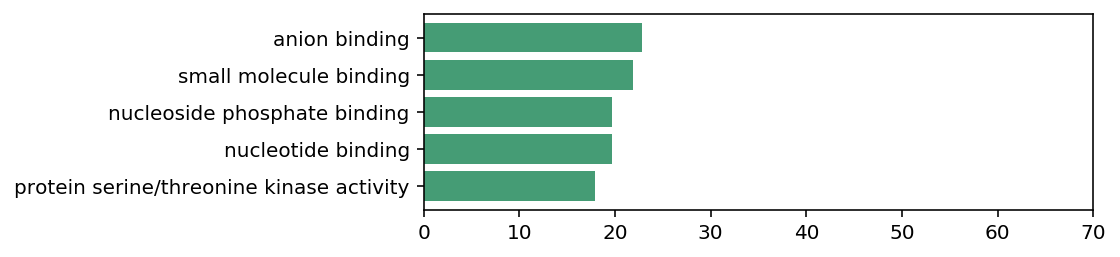

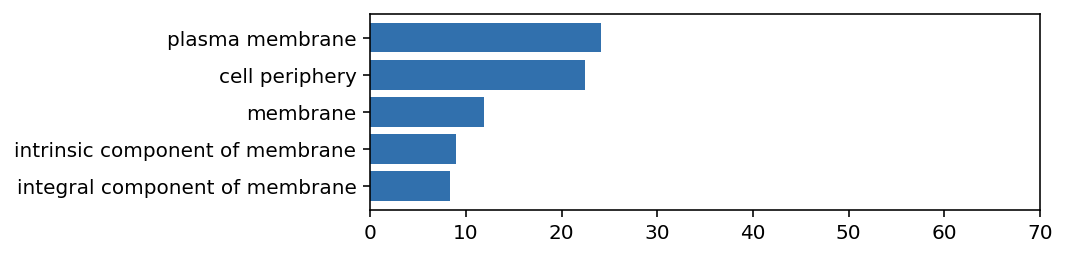

In [12]:
make_GO_top5_bar("wte2_GO.csv")

### comonn a4 and kv

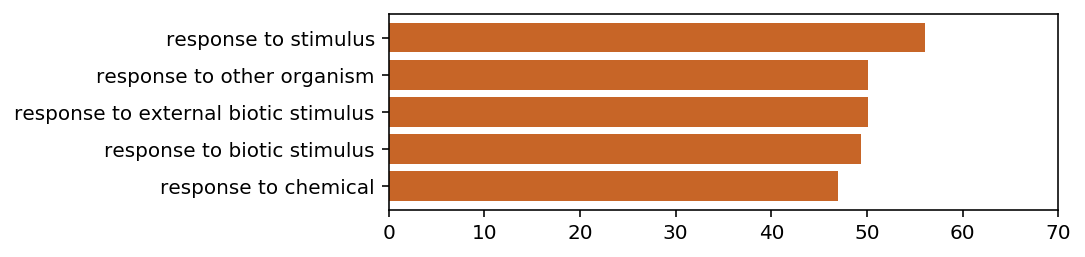

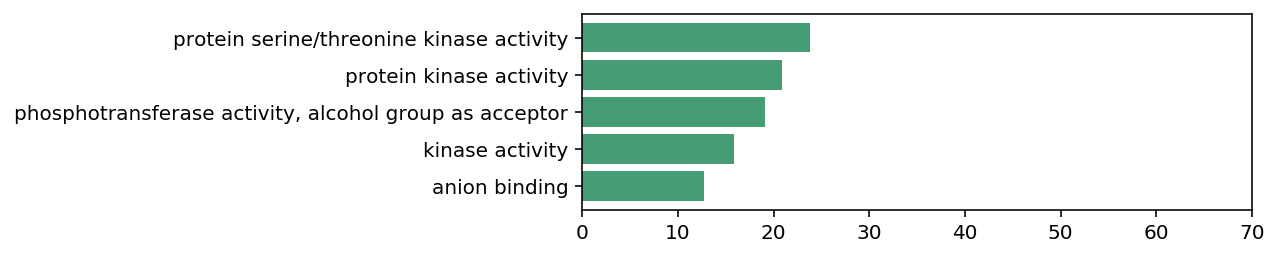

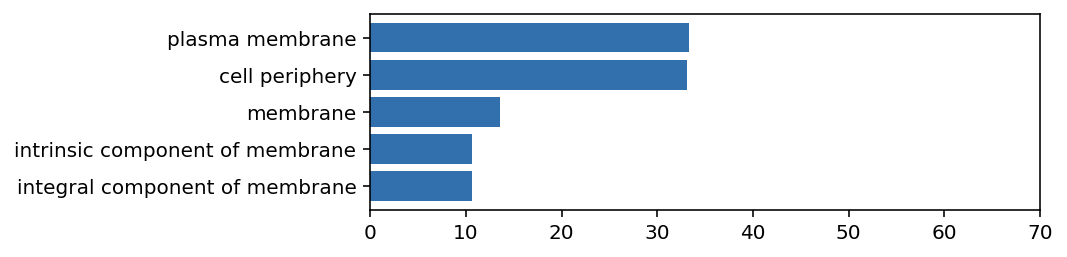

In [13]:
make_GO_top5_bar("wt_a4_kv_common_GO.csv")

# Venn diagram between wt_a4, wt_kv, setiwt_e2

RNA DEGs


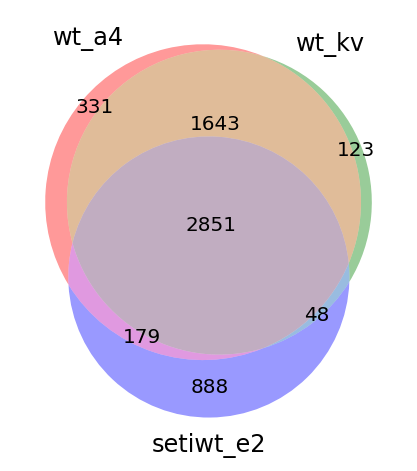

ATAC peak target genes


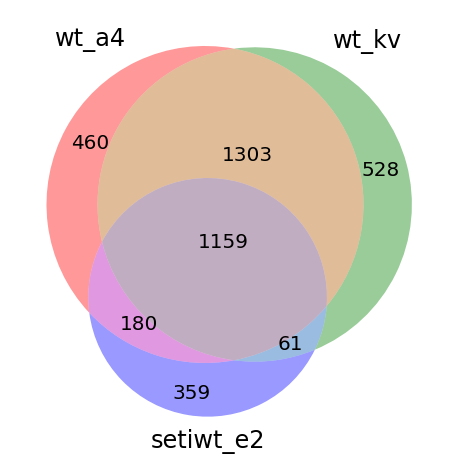

Consistent between ATAC&DEG


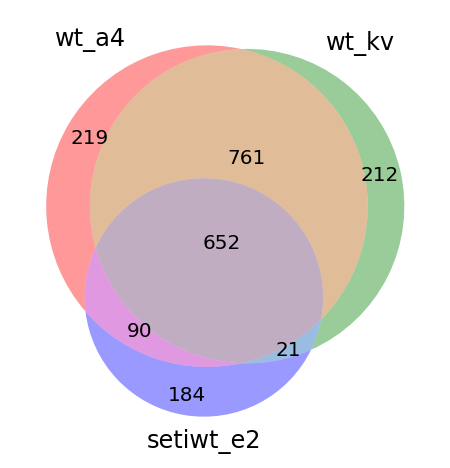

In [14]:
print("RNA DEGs")
a, b, c = len(a4_DEGs), len(kv_DEGs), len(setiwte2_DEGs)
ab, bc, ca = len(set(a4_DEGs)&set(kv_DEGs)), len(set(setiwte2_DEGs)&set(kv_DEGs)), len(set(a4_DEGs)&set(setiwte2_DEGs))
abc = len(set(a4_DEGs)&set(kv_DEGs)&set(setiwte2_DEGs))
venn3(subsets = (a-ab-ca+abc, b-bc-ab+abc, ab-abc, c-bc-ca+abc, ca-abc, bc-abc, abc), set_labels = ('wt_a4', 'wt_kv', 'setiwt_e2'))
plt.show()

print("ATAC peak target genes")
a, b, c = len(a4_ACRs), len(kv_ACRs), len(setiwte2_ACRs)
ab, bc, ca = len(set(a4_ACRs)&set(kv_ACRs)), len(set(setiwte2_ACRs)&set(kv_ACRs)), len(set(a4_ACRs)&set(setiwte2_ACRs))
abc = len(set(a4_ACRs)&set(kv_ACRs)&set(setiwte2_ACRs))
venn3(subsets = (a-ab-ca+abc, b-bc-ab+abc, ab-abc, c-bc-ca+abc, ca-abc, bc-abc, abc), set_labels = ('wt_a4', 'wt_kv', 'setiwt_e2'))
plt.show()

print("Consistent between ATAC&DEG")
a, b, c = len(a4_common), len(kv_common), len(setiwte2_common)
ab, bc, ca = len(set(a4_common)&set(kv_common)), len(set(setiwte2_common)&set(kv_common)), len(set(a4_common)&set(setiwte2_common))
abc = len(set(a4_common)&set(kv_common)&set(setiwte2_common))
venn3(subsets = (a-ab-ca+abc, b-bc-ab+abc, ab-abc, c-bc-ca+abc, ca-abc, bc-abc, abc), set_labels = ('wt_a4', 'wt_kv', 'setiwt_e2'))
plt.show()

### setiwt_e2 vs setikv_e2

setiwt_e2 vs setiwt_mk


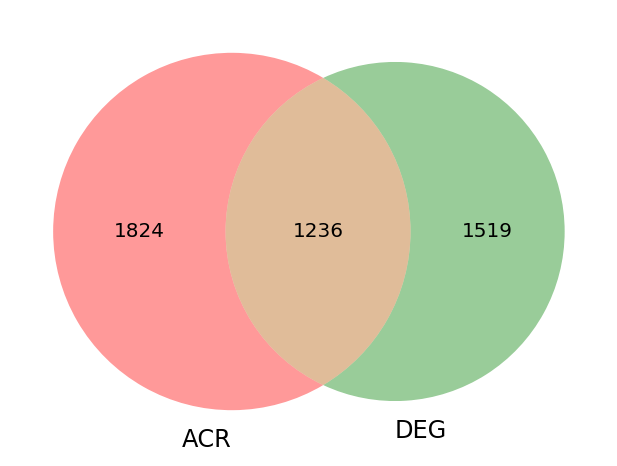

In [15]:
### setiwt_e2 vs setiwt_mk
DEG = pd.read_csv("../DEG/DE gene testing statistics.csv")
setie2_vs_kve2 = DEG[DEG["contrast"] == "seti.est4h-kv.est4h"]
setie2_vs_kve2 = setie2_vs_kve2[setie2_vs_kve2["log2FC"] >= 1]
setie2_vs_kve2 = np.unique(setie2_vs_kve2.target.values)

print("setiwt_e2 vs setiwt_mk")
setiwt_vs_setikv_e2_ACRs, setiwt_vs_setikv_e2_DEGs, setiwt_vs_setikv_e2_common = check_consistent("setiwt_e2_vs_setikv_e2_peaks.narrowPeak", "setiwt_e2_vs_setikv_e2_peaks_annotation.txt", setie2_vs_kve2, gff)